In [1]:
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.statespace.varmax import VARMAX
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
stk_data = yf.download("RELIANCE.NS", start="2021-06-01", end="2022-05-01")
print(stk_data.head())

[*********************100%***********************]  1 of 1 completed

Price             Close         High         Low         Open      Volume
Ticker      RELIANCE.NS  RELIANCE.NS RELIANCE.NS  RELIANCE.NS RELIANCE.NS
Date                                                                     
2021-06-01   987.374939  1002.443448  977.177463   986.054707    28013832
2021-06-02  1002.101990  1005.857738  981.957502   981.957502    24630162
2021-06-03  1005.925903  1024.294928  999.757398  1011.092856    23974257
2021-06-04   997.208069  1009.021575  994.362780  1008.270425    14468646
2021-06-07  1014.006409  1020.652962  994.704167  1002.443306    16336573


In [3]:
dataset = pd.read_csv("reliance_data.csv", skiprows=1)
import pandas as pd
# Flatten column MultiIndex if exists
if isinstance(stk_data.columns, pd.MultiIndex):
    stk_data.columns = [col[0] for col in stk_data.columns]

# Check data
print("Data fetched successfully!")
print(stk_data.head())

Data fetched successfully!
                  Close         High         Low         Open    Volume
Date                                                                   
2021-06-01   987.374939  1002.443448  977.177463   986.054707  28013832
2021-06-02  1002.101990  1005.857738  981.957502   981.957502  24630162
2021-06-03  1005.925903  1024.294928  999.757398  1011.092856  23974257
2021-06-04   997.208069  1009.021575  994.362780  1008.270425  14468646
2021-06-07  1014.006409  1020.652962  994.704167  1002.443306  16336573


In [4]:
stk_data=stk_data[["Open","High","Low","Close"]]
stk_data

,Open,High,Low,Close
Date,,,,
2021-06-01,986.054707,1002.443448,977.177463,987.374939
2021-06-02,981.957502,1005.857738,981.957502,1002.101990
2021-06-03,1011.092856,1024.294928,999.757398,1005.925903
2021-06-04,1008.270425,1009.021575,994.362780,997.208069
2021-06-07,1002.443306,1020.652962,994.704167,1014.006409
...,...,...,...,...
2022-04-25,1252.808769,1260.117952,1216.833432,1231.155029
2022-04-26,1238.007307,1276.837847,1236.956647,1267.998169
2022-04-27,1258.952988,1291.913249,1258.587463,1269.231689


In [5]:
scaler = MinMaxScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(stk_data), columns=stk_data.columns, index=stk_data.index)

In [6]:
train_size = int(len(data_scaled) * 0.8)
train = data_scaled.iloc[:train_size]
test = data_scaled.iloc[train_size:]

In [7]:
try:
    model = VARMAX(train, order=(1, 1))  # VARMA(1,1) style
    model_fit = model.fit(disp=False)
except Exception as e:
    print("Error fitting VARMAX(1,1):", e)
    model = VARMAX(train, order=(1, 0))  # fallback to VAR(1)
    model_fit = model.fit(disp=False)


In [8]:
start = len(train)
end = len(data_scaled) - 1
pred_scaled = model_fit.predict(start=start, end=end)

In [9]:
pred_orig = scaler.inverse_transform(pred_scaled)
test_orig = scaler.inverse_transform(test)

In [10]:
pred_df = pd.DataFrame(pred_orig, columns=stk_data.columns, index=test.index)
test_df = pd.DataFrame(test_orig, columns=stk_data.columns, index=test.index)

In [11]:
for col in stk_data.columns:
    rmse = mean_squared_error(test_df[col], pred_df[col], squared=False)
    mape = mean_absolute_percentage_error(test_df[col], pred_df[col]) * 100
    print(f"{col} - RMSE: {rmse:.2f}, MAPE: {mape:.2f}%")


Open - RMSE: 96.62, MAPE: 6.74%
High - RMSE: 100.11, MAPE: 6.78%
Low - RMSE: 97.90, MAPE: 6.94%
Close - RMSE: 100.08, MAPE: 6.92%


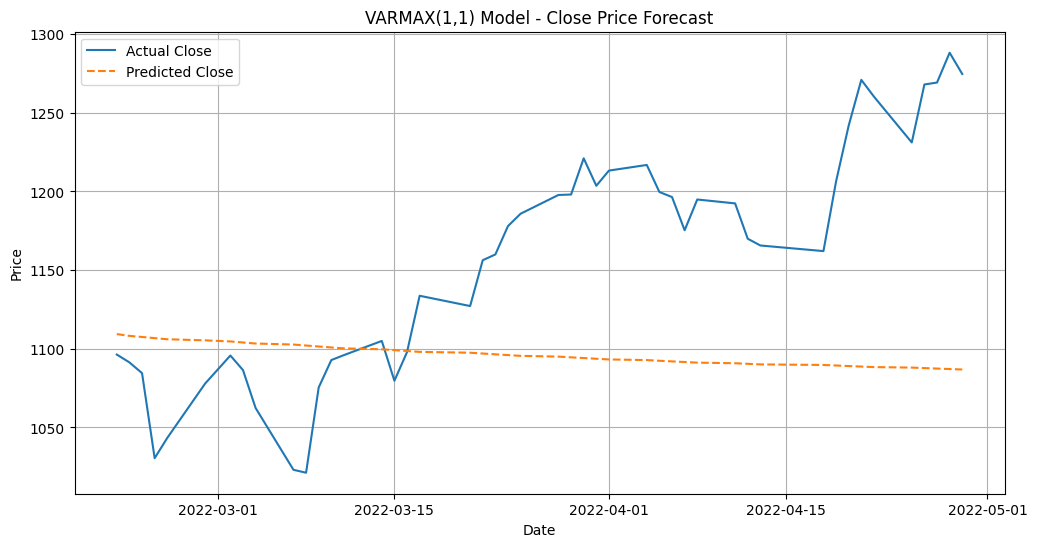

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(test_df["Close"], label="Actual Close")
plt.plot(pred_df["Close"], label="Predicted Close", linestyle='--')
plt.title("VARMAX(1,1) Model - Close Price Forecast")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()